In [1]:
import itertools
import random
import re

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
VOCABULARY = [str(d) for d in range(10)] + ['+', '=', 'Q', 'E', 'F', '!']
VOCABULARY

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '+',
 '=',
 'Q',
 'E',
 'F',
 '!']

In [3]:
def data(n_samples, max_n_digits, seed, min_n_digits=1):
    random.seed(seed)
    already_generated = set()
    
    while True:
        if len(already_generated) >= n_samples:
            break
        
        n_digits = random.randint(min_n_digits, max_n_digits)
        
        a = random.randint(0, 10 ** n_digits - 1)
        b = random.randint(0, 10 ** n_digits - 1)
        
        if (a, b) in already_generated:
            continue
        
        already_generated.add((a, b))
        
        problem = f'{a:0{n_digits}d}+{b:0{n_digits}d}'

        carry = 0
        
        for significance in range(n_digits):
            a_digit = (a // 10 ** significance) % 10
            b_digit = (b // 10 ** significance) % 10
            result = a_digit + b_digit + carry
            result_digit = result % 10
            result_carry = result // 10
            problem += f'Q{carry}+{a_digit}+{b_digit}E{result_carry}{result_digit}'
            carry = result_carry
        
        problem += f'F{a+b}!'
        
        yield problem

next(data(100, 3, 0))

'97+53Q0+7+3E10Q1+9+5E15F150!'

In [4]:
def tokenize(s):
    s = list(s)
    return np.array([VOCABULARY.index(c) for c in s])

def detokenize(arr):
    return ''.join([VOCABULARY[x] for x in arr])

In [5]:
def system_1(s):
    return f'{eval(s):02d}'

system_1('7+1+0')

'08'

In [6]:
def data_generator(dataset):
    for example in dataset:
        idxs = [(m.start(0), m.end(0))
                for m in re.finditer('Q.\+.\+.E|F.*!', example[1:])]
        
        tokens = tokenize(example)
        inputs = tokens[:-1]
        targets = tokens[1:]
        
        mask = np.array([0] * len(targets))
        for s, e in idxs:
            mask[s:e] = 1
        
        yield inputs, targets, mask

In [7]:
def decode(model, a, b):
    n_digits = max(len(str(a)), len(str(b)))
    ex = f"{a:0{n_digits}d}+{b:0{n_digits}d}"
    tokenized = tokenize(ex)
    
    while True:
        while not tokenized[-1] in (VOCABULARY.index('E'), VOCABULARY.index('!')):
            pred = model(tokenized[np.newaxis, ...]).numpy()
            next_token = np.argmax(pred, axis=-1)[0, -1]
            tokenized = np.append(tokenized, next_token)

        if tokenized[-1] == VOCABULARY.index('E'):
            # Call system 1
            query = detokenize(tokenized)[-6:-1]
            ans = system_1(query)
            tokenized_ans = tokenize(ans)
            tokenized = np.append(tokenized, tokenized_ans)

        elif tokenized[-1] == VOCABULARY.index('!'):
            break

    return detokenize(tokenized)

In [8]:
def evaluate(model, test_dataset):
    n_correct = 0
    for example in test_dataset:
        i = example.index('Q')
        ab = example[:i]
        i = ab.index('+')
        a = int(ab[:i])
        b = int(ab[i:])

        try:
            ans = decode(model, a, b)
            i = ans.index('F')
            ans = ans[i+1:-1]
            ans = int(ans)

            if ans == a + b:
                n_correct += 1
        except:
            pass

    return n_correct / len(test_dataset)

In [9]:
def build_model(vocab_size, use_attention):
    inputs = layers.Input((None,))
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    if use_attention:
        seq_len = tf.shape(x)[1]
        keys = layers.Dense(128)(x)
        look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
        look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
        attention_scores = x @ tf.transpose(keys, [0, 2, 1])
        attention_scores = attention_scores + look_ahead_mask
        attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
        x_att = attention_weights @ x
        x = layers.Concatenate()([x, x_att])
    
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [10]:
def run_experiment(train_dataset, test_dataset, use_attention):
    tf.keras.backend.clear_session()
    
    vocab_size = len(VOCABULARY)
    model = build_model(vocab_size, use_attention)

    optimizer = optimizers.Adam(1e-3)

    model.build(input_shape=(None, None))
    model.summary()

    train_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(train_dataset),
        output_types=(tf.int32, tf.int32, tf.int32),
        output_shapes=(
            tf.TensorShape((None,)), 
            tf.TensorShape((None,)), 
            tf.TensorShape((None,))
        ))
    train_ds = train_ds.shuffle(10000)
    train_ds = train_ds.padded_batch(16, padded_shapes=([None], [None], [None]))

    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    @tf.function
    def train_step(inputs, targets, mask):
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            loss = tf.losses.sparse_categorical_crossentropy(targets, outputs)
            loss = tf.boolean_mask(loss, tf.cast(mask, tf.bool))
            loss = tf.reduce_mean(loss)

            masked_outputs = tf.boolean_mask(outputs, tf.cast(mask, tf.bool))
            accuracy(targets, outputs, sample_weight=mask)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

    for i, (inputs, targets, mask) in train_ds.repeat(None).take(4000).enumerate():
        accuracy.reset_states()
        loss = train_step(inputs, targets, mask)
        if i % 100 == 0 and i > 0:
            print(
                'Step', i.numpy(),
                'Loss', loss.numpy(),
                'Acc', accuracy.result().numpy())
    
    accuracy = evaluate(model, test_dataset)
    return accuracy, model

## Baseline

In [11]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    accuracy, _ = run_experiment(train_dataset, test_dataset, use_attention=False)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          1024      
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 16)          2064      
Total params: 101,904
Trainable params: 101,904
Non-trainable params: 0
_________________________________________________________________


UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model/lstm/StatefulPartitionedCall]] [Op:__inference_train_step_3051]

Function call stack:
train_step -> train_step -> train_step


In [ ]:
accuracies

## Baseline + self attention

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(3,)]               0           lstm[0][0]                       
______________________________________________________________________________________________

Step 100 Loss 1.9898735 Acc 0.32971016
Step 200 Loss 0.99012864 Acc 0.66793895
Step 300 Loss 0.8520586 Acc 0.69473684
Step 400 Loss 0.74131805 Acc 0.74169743
Step 500 Loss 0.7321281 Acc 0.7394636
Step 600 Loss 0.699945 Acc 0.7490494
Step 700 Loss 0.67464167 Acc 0.7557252
Step 800 Loss 0.6465579 Acc 0.76981133
Step 900 Loss 0.6057996 Acc 0.8015267
Step 1000 Loss 0.5836463 Acc 0.810219
Step 1100 Loss 0.42980906 Acc 0.87649405
Step 1200 Loss 0.41732126 Acc 0.8774704
Step 1300 Loss 0.31744236 Acc 0.91007197
Step 1400 Loss 0.3068247 Acc 0.905303
Step 1500 Loss 0.21554098 Acc 0.9421769
Step 1600 Loss 0.22441018 Acc 0.93050194
Step 1700 Loss 0.18656848 Acc 0.95272726
Step 1800 Loss 0.13914895 Acc 0.9651568
Step 1900 Loss 0.14914002 Acc 0.9520295
Step 2000 Loss 0.081030026 Acc 0.98916966
Step 2100 Loss 0.07244222 Acc 0.98046875
Step 2200 Loss 0.07107093 Acc 0.984375
Step 2300 Loss 0.049197726 Acc 0.9965278
Step 2400 Loss 0.03661329 Acc 0.9961832
Step 2500 Loss 0.03013873 Acc 0.9962825
Step 260

Step 100 Loss 1.8116287 Acc 0.42857143
Step 200 Loss 0.9507092 Acc 0.6840278
Step 300 Loss 0.80750275 Acc 0.7003367
Step 400 Loss 0.7629979 Acc 0.7133106
Step 500 Loss 0.70806277 Acc 0.762069
Step 600 Loss 0.6878488 Acc 0.75165564
Step 700 Loss 0.6604581 Acc 0.779661
Step 800 Loss 0.5838169 Acc 0.8263889
Step 900 Loss 0.5539381 Acc 0.8361204
Step 1000 Loss 0.4969657 Acc 0.8333333
Step 1100 Loss 0.44052565 Acc 0.85423726
Step 1200 Loss 0.37060526 Acc 0.8783784
Step 1300 Loss 0.30904925 Acc 0.8993289
Step 1400 Loss 0.2528461 Acc 0.9151291
Step 1500 Loss 0.19364119 Acc 0.9522059
Step 1600 Loss 0.17364648 Acc 0.9547038
Step 1700 Loss 0.13346103 Acc 0.9652778
Step 1800 Loss 0.07725545 Acc 0.9896194
Step 1900 Loss 0.04315991 Acc 0.9932432
Step 2000 Loss 0.037057817 Acc 1.0
Step 2100 Loss 0.030888809 Acc 0.9932432
Step 2200 Loss 0.03366283 Acc 1.0
Step 2300 Loss 0.023877416 Acc 0.9965157
Step 2400 Loss 0.010960712 Acc 1.0
Step 2500 Loss 0.0072420896 Acc 1.0
Step 2600 Loss 0.009338946 Acc 1.0


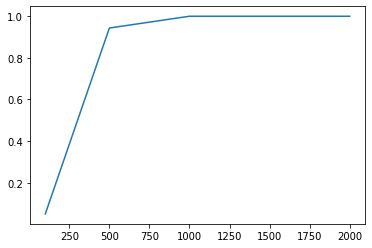

In [13]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    accuracy, _ = run_experiment(train_dataset, test_dataset, use_attention=True)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [14]:
accuracies

[0.05, 0.9433333333333334, 1.0, 1.0]

## Increasing num digits in training data

In [21]:
train_dataset = data(
    n_samples=5000,
    max_n_digits=4,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=500,
    max_n_digits=5,
    min_n_digits=5,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, use_attention=True)
print(accuracy)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(3,)]               0           lstm[0][0]                       
______________________________________________________________________________________________

In [ ]:
print(detokenize(decode(model, 11111, 22222)))

Softmax output:
tf.Tensor(
[2.8037343e-11 5.2746945e-09 1.8141233e-10 1.4013974e-09 7.9117997e-11
 3.3210892e-10 1.3350846e-09 5.2551175e-11 8.3795415e-11 2.2186410e-09
 5.5160859e-10 2.0774592e-11 9.9997485e-01 1.9936708e-05 5.1865363e-06
 5.8551095e-11], shape=(16,), dtype=float32)
Argmax token: Q
Attention weights:


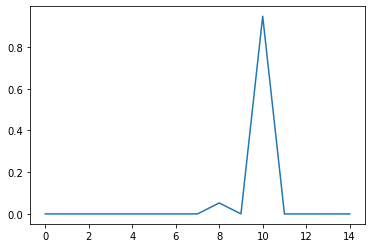

In [53]:
ex = "123+567Q0+3+7E1"
tokenized = tokenize(ex)

model = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, model.get_layer('tf_op_layer_Softmax').output])

pred, att_weights = model(tokenized[np.newaxis, ...])
print("Softmax output:")
print(pred[0][0, -1, :])
print('Argmax token:', VOCABULARY[np.argmax(pred[0][0, -1, :])])

print("Attention weights:")
plt.plot(att_weights[0, -1, :])